# Metashift Cats & Dogs Dataset
- download link: https://drive.google.com/file/d/1P2kvXa_erLVHBqL_0RDe5HLmpnA1rz2I/view?usp=sharing
- Subpopulation size
    - Majority: cat-indoor (2171 images) + dog-outdoor (2171 images)
    - Minority: cat-indoor (288 images) + dog-outdoor (288 images)    

In [10]:
ROOT_PATH = "cleaned_MetaShift_Cat_Dog/" # downloaded dataset root path
EXP_ROOT_PATH = '../../experiments/metashift' # experiment root path

In [6]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

from tqdm.notebook import trange, tqdm

In [7]:
cls_name = ['cat', 'dog']
domain_name = ['indoor', 'outdoor']
img_list = {}

for c in cls_name:
    for d in domain_name:
        img_list[c+'('+d+')'] = os.listdir(os.path.join(ROOT_PATH, 'COCO', c+'('+d+')'))
        for i,img in enumerate(img_list[c+'('+d+')']):
            img_list[c+'('+d+')'][i] = os.path.join(ROOT_PATH, 'COCO', c+'('+d+')', img)
        temp_len = len(img_list[c+'('+d+')'])
        img_list[c+'('+d+')'] += os.listdir(os.path.join(ROOT_PATH, 'VisualGenome', c+'('+d+')'))
        for i,img in enumerate(img_list[c+'('+d+')'][temp_len:]):
            img_list[c+'('+d+')'][i+temp_len] = os.path.join(ROOT_PATH, 'VisualGenome', c+'('+d+')', img)
        random.Random(42).shuffle(img_list[c+'('+d+')'])
        

## Dataset samples

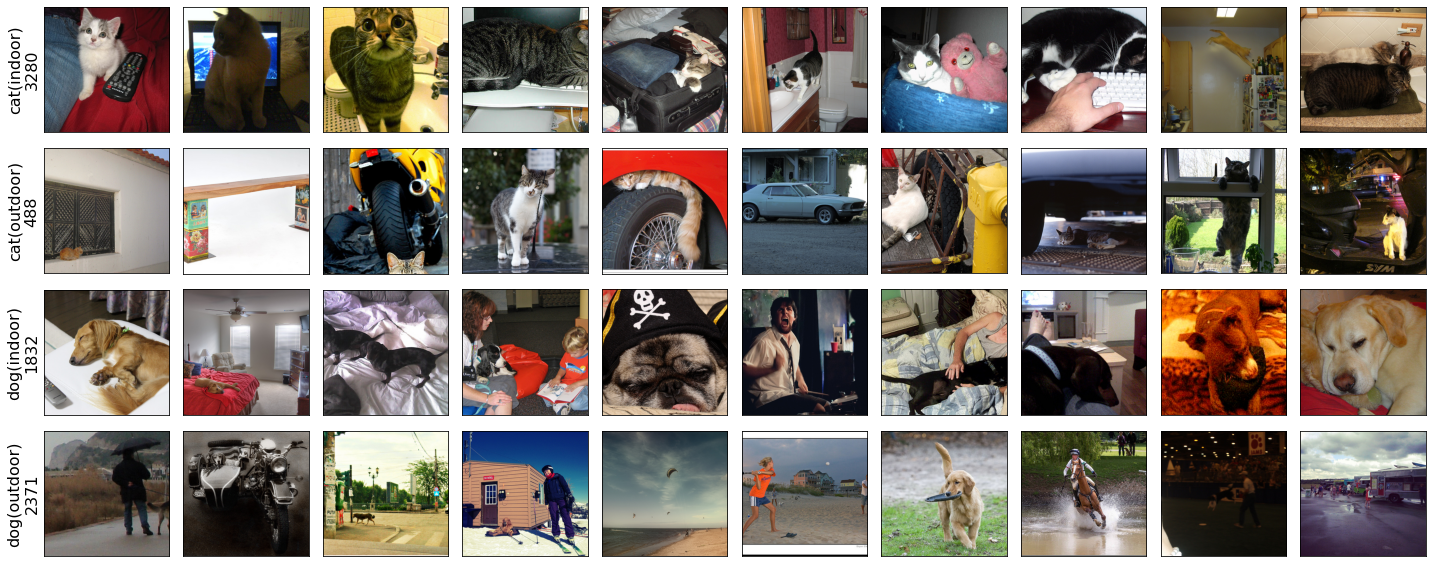

In [8]:
plt.figure(figsize=(20,len(img_list)*2))
for i, (k,v) in enumerate(img_list.items()):
    for j in range(10):
        img = Image.open(os.path.join(v[j]))
        w,h = img.size
        s = min(w,h)
        img = img.crop(((w-s)/2,(h-s)/2,(w+s)/2,(h+s)/2))
        plt.subplot(len(img_list), 10, i*10+j+1)
        plt.imshow(img)
        plt.ylabel(k+'\n'+str(len(v)), fontsize=16) if j==0 else None
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()
plt.close()

## Prepare data

In [ ]:
TRAIN_NUM = [2171, 288] # [majority, minority] for each class
VAL_NUM   = [200, 200] # [majority, minority] for each class
cls_domain = {'cat(indoor)': 0, 'cat(outdoor)':1, 'dog(outdoor)':0, 'dog(indoor)':1} # 0:major; 1:minor
print('majority : minority = {:.2f} : {:.2f}'.format(\
    TRAIN_NUM[0]/(TRAIN_NUM[0]+TRAIN_NUM[1]), TRAIN_NUM[1]/(TRAIN_NUM[0]+TRAIN_NUM[1])))

domain_id = ['majority-val', 'minority-val']
split_list = {'train':{}, 'majority-val':{}, 'minority-val':{}}

for c in cls_name:
    for k in split_list.keys():
        split_list[k][c] = []

for cd, id in cls_domain.items():
    split_list['train'][cd[:3]] += img_list[cd][:TRAIN_NUM[id]]
    split_list[domain_id[id]][cd[:3]] += img_list[cd][-VAL_NUM[id]:] # select val data backwards
        
# Data Loading
DATA_ROOT_PATH = os.path.join(EXP_ROOT_PATH, 'data') 
if os.path.exists(DATA_ROOT_PATH) and os.path.isdir(DATA_ROOT_PATH):
    shutil.rmtree(DATA_ROOT_PATH)
os.makedirs(DATA_ROOT_PATH, exist_ok = False)

for k,v in split_list.items():
    for i_cls, (c,img_paths) in enumerate(v.items()):
        os.makedirs(os.path.join(DATA_ROOT_PATH, k, str(i_cls)) , exist_ok = True)
        print(DATA_ROOT_PATH, k, i_cls, c)
        for i_img,img_path in tqdm(enumerate(img_paths)):
            pil_img = Image.open(img_path)
            dst_path = os.path.join(DATA_ROOT_PATH, k, str(i_cls), str(i_img)+'.jpg')
            pil_img.save(dst_path)